# Importing Necessary Libraries

In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt


# Importing and Preparing Data

In [12]:
class ImageMaskDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
# This was done due to .txt belonging to the images folder. It was counting the .txt file as an image[0]
    
        self.images = [f for f in sorted(os.listdir(images_dir)) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.masks = [f for f in sorted(os.listdir(masks_dir)) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB") 

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask=(mask>0.5).float()
        
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
])

# Create dataset
dataset = ImageMaskDataset(images_dir='/kaggle/input/ham1000-segmentation-and-classification/images', masks_dir='/kaggle/input/ham1000-segmentation-and-classification/masks', transform=transform)

# Set the split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the lengths for each split
total_size = len(dataset)


# Calculate the lengths for each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [13]:
import numpy as np

img, mask = train_dataset[0]

print(img.shape)

import cv2

image=cv2.imread("/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg")
Mask=image=cv2.imread("/kaggle/input/ham1000-segmentation-and-classification/masks/ISIC_0024306_segmentation.png")

print(image.shape)

print(f'Original mask shape:{Mask.shape}')
#print(Mask[:, 20:30, 20:30])

print(np.unique(Mask))


#print(mask)
print(mask.shape)

print(torch.unique(mask))

print(torch.unique(mask).numel())

#print("Subset of the tensor:")
#print(mask[:, 50:60, 50:60])  # Print only a small corner of the tensor

torch.Size([3, 128, 128])
(450, 600, 3)
Original mask shape:(450, 600, 3)
[  0 255]
torch.Size([3, 128, 128])
tensor([0., 1.])
2


# Visualizing the Data

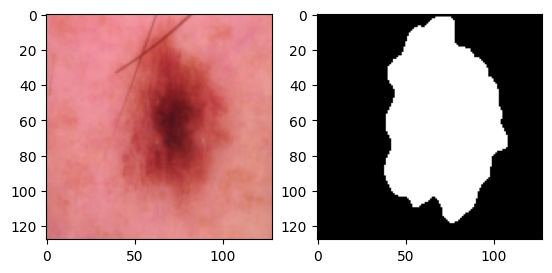

In [14]:
img,mask=dataset[0]
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0))
plt.show()

# Applying the Model

# Basic UNet

In [15]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)
        
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        # Output
        out = torch.sigmoid(self.out_conv(dec1))
        
        return out

# Attention UNet

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(AttentionUNet, self).__init__()

        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        enc4 = self.attention4(dec4, enc4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        enc3 = self.attention3(dec3, enc3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        enc2 = self.attention2(dec2, enc2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        enc1 = self.attention1(dec1, enc1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.output(dec1)

# CBAM-BAM U-Net

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)
    
    def forward(self, x):
        # Channel attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_out = self.sigmoid(avg_out + max_out)
        x = x * channel_out

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_out, max_out], dim=1)
        spatial_out = self.sigmoid(self.conv_spatial(spatial_out))
        return x * spatial_out

class BAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(BAM, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.attention(x)

class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetWithAttention, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        self.bottleneck = self.conv_block(512, 1024)
        self.bam_bottleneck = BAM(1024)  # Adding BAM to the bottleneck
        
        # Decoder path with CBAM only in the skip connections
        self.decoder4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.cbam4 = CBAM(512)  # CBAM applied at skip connection for encoder4 output
        self.upconv4 = self.conv_block(1024, 512)  # Double convolution after concatenation
        
        self.decoder3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.cbam3 = CBAM(256)  # CBAM applied at skip connection for encoder3 output
        self.upconv3 = self.conv_block(512, 256)  # Double convolution after concatenation
        
        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.cbam2 = CBAM(128)  # CBAM applied at skip connection for encoder2 output
        self.upconv2 = self.conv_block(256, 128)  # Double convolution after concatenation
        
        self.decoder1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cbam1 = CBAM(64)   # CBAM applied at skip connection for encoder1 output
        self.upconv1 = self.conv_block(128, 64)   # Double convolution after concatenation
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)  # 3 channels -> 64 channels
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))  # 64 channels -> 128 channels
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))  # 128 channels -> 256 channels
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))  # 256 channels -> 512 channels
        
        # Bottleneck with BAM applied
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))  # 512 channels -> 1024 channels
        bottleneck = self.bam_bottleneck(bottleneck)  # Apply BAM to the bottleneck
        
        # Decoder path with CBAM in skip connections
        dec4 = self.decoder4(bottleneck)  # 1024 channels -> 512 channels
        enc4 = self.cbam4(enc4)  # Apply CBAM to encoder output before skip connection
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection with encoder layer
        dec4 = self.upconv4(dec4)  # Double convolution after concatenation
        
        dec3 = self.decoder3(dec4)  # 512 channels -> 256 channels
        enc3 = self.cbam3(enc3)  # Apply CBAM to encoder output before skip connection
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection with encoder layer
        dec3 = self.upconv3(dec3)  # Double convolution after concatenation
        
        dec2 = self.decoder2(dec3)  # 256 channels -> 128 channels
        enc2 = self.cbam2(enc2)  # Apply CBAM to encoder output before skip connection
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection with encoder layer
        dec2 = self.upconv2(dec2)  # Double convolution after concatenation
        
        dec1 = self.decoder1(dec2)  # 128 channels -> 64 channels
        enc1 = self.cbam1(enc1)  # Apply CBAM to encoder output before skip connection
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection with encoder layer
        dec1 = self.upconv1(dec1)  # Double convolution after concatenation
        
        return self.final_conv(dec1)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        
        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)
    
    def forward(self, x):
        # Channel attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_out = self.sigmoid(avg_out + max_out)
        x = x * channel_out

        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_out, max_out], dim=1)
        spatial_out = self.sigmoid(self.conv_spatial(spatial_out))
        return x * spatial_out

class BAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(BAM, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return x * self.attention(x)

class UNetWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetWithAttention, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        self.bottleneck = self.conv_block(512, 1024)
        self.bam_bottleneck = BAM(1024)  # Adding BAM to the bottleneck
        
        # Decoder path with CBAM only in the skip connections
        self.decoder4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.cbam4 = CBAM(512)  # CBAM applied at skip connection for encoder4 output
        self.upconv4 = self.conv_block(1024, 512)  # Double convolution after concatenation
        
        self.decoder3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.cbam3 = CBAM(256)  # CBAM applied at skip connection for encoder3 output
        self.upconv3 = self.conv_block(512, 256)  # Double convolution after concatenation
        
        self.decoder2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.cbam2 = CBAM(128)  # CBAM applied at skip connection for encoder2 output
        self.upconv2 = self.conv_block(256, 128)  # Double convolution after concatenation
        
        self.decoder1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.cbam1 = CBAM(64)   # CBAM applied at skip connection for encoder1 output
        self.upconv1 = self.conv_block(128, 64)   # Double convolution after concatenation
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)  # 3 channels -> 64 channels
        print(f"enc1 output shape: {enc1.shape}")
        
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))  # 64 channels -> 128 channels
        print(f"enc2 output shape: {enc2.shape}")
        
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))  # 128 channels -> 256 channels
        print(f"enc3 output shape: {enc3.shape}")
        
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))  # 256 channels -> 512 channels
        print(f"enc4 output shape: {enc4.shape}")
        
        # Bottleneck with BAM applied
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))  # 512 channels -> 1024 channels
        print(f"bottleneck output shape: {bottleneck.shape}")
        
        bottleneck = self.bam_bottleneck(bottleneck)  # Apply BAM to the bottleneck
        print(f"bottleneck after BAM: {bottleneck.shape}")
        
        # Decoder path with CBAM in skip connections
        dec4 = self.decoder4(bottleneck)  # 1024 channels -> 512 channels
        print(f"dec4 output shape before skip: {dec4.shape}")
        
        enc4 = self.cbam4(enc4)  # Apply CBAM to encoder output before skip connection
        print(f"enc4 after CBAM: {enc4.shape}")
        
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection with encoder layer
        print(f"dec4 after concatenation: {dec4.shape}")
        
        dec4 = self.upconv4(dec4)  # Double convolution after concatenation
        print(f"dec4 after upconv4: {dec4.shape}")
        
        dec3 = self.decoder3(dec4)  # 512 channels -> 256 channels
        print(f"dec3 output shape before skip: {dec3.shape}")
        
        enc3 = self.cbam3(enc3)  # Apply CBAM to encoder output before skip connection
        print(f"enc3 after CBAM: {enc3.shape}")
        
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection with encoder layer
        print(f"dec3 after concatenation: {dec3.shape}")
        
        dec3 = self.upconv3(dec3)  # Double convolution after concatenation
        print(f"dec3 after upconv3: {dec3.shape}")
        
        dec2 = self.decoder2(dec3)  # 256 channels -> 128 channels
        print(f"dec2 output shape before skip: {dec2.shape}")
        
        enc2 = self.cbam2(enc2)  # Apply CBAM to encoder output before skip connection
        print(f"enc2 after CBAM: {enc2.shape}")
        
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection with encoder layer
        print(f"dec2 after concatenation: {dec2.shape}")
        
        dec2 = self.upconv2(dec2)  # Double convolution after concatenation
        print(f"dec2 after upconv2: {dec2.shape}")
        
        dec1 = self.decoder1(dec2)  # 128 channels -> 64 channels
        print(f"dec1 output shape before skip: {dec1.shape}")
        
        enc1 = self.cbam1(enc1)  # Apply CBAM to encoder output before skip connection
        print(f"enc1 after CBAM: {enc1.shape}")
        
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection with encoder layer
        print(f"dec1 after concatenation: {dec1.shape}")
        
        dec1 = self.upconv1(dec1)  # Double convolution after concatenation
        print(f"dec1 after upconv1: {dec1.shape}")
        
        out = self.final_conv(dec1)
        print(f"out after final_conv: {out.shape}")
        
        return out

model = UNetWithAttention(in_channels=3, out_channels=3)  # Example with 3 input channels (RGB) and 1 output channel (e.g., segmentation map)

# Create a dummy input tensor (batch size of 1, 3 channels, 256x256 image)
dummy_input = torch.randn(8, 3, 128, 128)

# Run the forward pass
output = model(dummy_input)

enc1 output shape: torch.Size([8, 64, 128, 128])
enc2 output shape: torch.Size([8, 128, 64, 64])
enc3 output shape: torch.Size([8, 256, 32, 32])
enc4 output shape: torch.Size([8, 512, 16, 16])
bottleneck output shape: torch.Size([8, 1024, 8, 8])
bottleneck after BAM: torch.Size([8, 1024, 8, 8])
dec4 output shape before skip: torch.Size([8, 512, 16, 16])
enc4 after CBAM: torch.Size([8, 512, 16, 16])
dec4 after concatenation: torch.Size([8, 1024, 16, 16])
dec4 after upconv4: torch.Size([8, 512, 16, 16])
dec3 output shape before skip: torch.Size([8, 256, 32, 32])
enc3 after CBAM: torch.Size([8, 256, 32, 32])
dec3 after concatenation: torch.Size([8, 512, 32, 32])
dec3 after upconv3: torch.Size([8, 256, 32, 32])
dec2 output shape before skip: torch.Size([8, 128, 64, 64])
enc2 after CBAM: torch.Size([8, 128, 64, 64])
dec2 after concatenation: torch.Size([8, 256, 64, 64])
dec2 after upconv2: torch.Size([8, 128, 64, 64])
dec1 output shape before skip: torch.Size([8, 64, 128, 128])
enc1 after C

# Loss Functions

# Dice Loss

In [18]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        # Apply sigmoid to the inputs if necessary
        inputs = torch.sigmoid(inputs)
        
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        total = inputs.sum() + targets.sum()
        
        # Compute Dice coefficient
        dice_coeff = (2.0 * intersection + self.smooth) / (total + self.smooth)
        
        # Dice loss is 1 - Dice coefficient
        dice_loss = 1.0 - dice_coeff
        
        return dice_loss

# Focal Loss

In [19]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        # Apply sigmoid if necessary
        inputs = torch.sigmoid(inputs)
        
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Compute the binary cross-entropy loss
        BCE_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Compute the focal weight
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        # Apply reduction method (mean, sum, or none)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Training Model

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        #torch.cuda.empty_cache()
        running_train_loss = 0.0
        train_iou_sum = 0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        train_dice_sum = 0
        train_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)  # Do not apply sigmoid here
            loss = criterion(outputs, labels)
            loss.backward()
            #loss.detach()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs.size(0)
            train_precision_sum += precision * inputs.size(0)
            train_recall_sum += recall * inputs.size(0)
            train_dice_sum += dice * inputs.size(0)
            train_iou_sum += iou * inputs.size(0)
            train_samples += inputs.size(0)
        
        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples
        
        model.eval()
        running_val_loss = 0.0
        val_iou_sum = 0
        val_acc_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_dice_sum = 0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs.size(0)
                val_precision_sum += precision * inputs.size(0)
                val_recall_sum += recall * inputs.size(0)
                val_dice_sum += dice * inputs.size(0)
                val_iou_sum += iou * inputs.size(0)
                val_samples += inputs.size(0)
        
        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')

def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)
    
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
    
    # IoU
    iou = tp / (tp + fp + fn + 1e-6)
    
    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    
    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#model = UNet().to(device)
model = UNet_CBAM_BAM().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, device=device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Final Test Performance

In [ ]:
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss = 0.0
    test_iou_sum = 0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_test_loss += loss.item() * inputs.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            test_acc_sum += acc * inputs.size(0)
            test_precision_sum += precision * inputs.size(0)
            test_recall_sum += recall * inputs.size(0)
            test_dice_sum += dice * inputs.size(0)
            test_iou_sum += iou * inputs.size(0)
            test_samples += inputs.size(0)
    
    epoch_test_loss = running_test_loss / test_samples
    epoch_test_iou = test_iou_sum / test_samples
    epoch_test_acc = test_acc_sum / test_samples
    epoch_test_precision = test_precision_sum / test_samples
    epoch_test_recall = test_recall_sum / test_samples
    epoch_test_dice = test_dice_sum / test_samples
    
    print(f'Test Loss: {epoch_test_loss:.4f} | '
          f'Test IoU: {epoch_test_iou:.4f} | '
          f'Test Acc: {epoch_test_acc:.4f} | '
          f'Test Precision: {epoch_test_precision:.4f} | '
          f'Test Recall: {epoch_test_recall:.4f} | '
          f'Test Dice: {epoch_test_dice:.4f}')
    
#     return {
#         'loss': epoch_test_loss,
#         'iou': epoch_test_iou,
#         'accuracy': epoch_test_acc,
#         'precision': epoch_test_precision,
#         'recall': epoch_test_recall,
#         'dice': epoch_test_dice
#     }

# Example usage:
test_model(model, test_loader, criterion, device=device)